In [3]:
import pandas as pd
import seaborn as sns
import json
import os
import re
import shutil
from datetime import datetime

data_out_dir = "./data/tables"

def convert_to_datetime_format(input):
    input_string = str(input)
    try:
        # If the input is a valid timestamp in milliseconds (10+ digits), convert it
        if len(input_string) > 10:  # it's in milliseconds
            timestamp = int(input_string) / 1000
        else:  # It's in seconds
            timestamp = int(input_string)

        # Convert the timestamp to a datetime object
        dt_object = datetime.utcfromtimestamp(timestamp)

        # Return the formatted string
        return dt_object.strftime('%Y-%m-%d %H:%M')
    
    except ValueError:
        # If input is in "YYYY-MM-DD HH:mm" format already, return it unchanged
        try:
            datetime.strptime(input_string, "%Y-%m-%d %H:%M")
            return input_string
        except ValueError:
            raise ValueError("Invalid input format")

def normalize_csv_timestamps(csv_path):
    """
    Normalize the first column of a CSV file to Unix timestamps with second precision.
    
    Args:
        csv_path: Path to the CSV file to normalize
    
    Returns:
        DataFrame with normalized timestamps and mapping from original to normalized
    """
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Get the first column name
    time_col = df.columns[0]
    
    # Try to parse the time column
    try:
        # Try parsing as datetime first (handles formats like "2025-07-27 21:02")
        df[time_col] = df[time_col].apply(convert_to_datetime_format)
    except:
        print(f"Warning: Could not parse time column in {csv_path}")
        return df, {}
        
    # Save the normalized CSV
    df.to_csv(csv_path, index=False)
    
    # Create mapping: row index -> timestamp
    timestamp_map = {idx: ts for idx, ts in enumerate(df[time_col])}
    
    return df, timestamp_map

def handle_labels_in_single_file(labels_in_file_json: json, labels_json: json, current_input_dir, next_file_id):
    # Ensure output structure
    if 'files' not in labels_json:
        labels_json['files'] = []
    if 'labels' not in labels_json:
        labels_json['labels'] = []

    # Skip file if it has 0 annotations
    annotations = labels_in_file_json.get('annotations', []) if isinstance(labels_in_file_json, dict) else []
    if not annotations or len(annotations) == 0:
        return next_file_id
    label_count = sum(len(a.get('result', [])) for a in annotations)
    if label_count < 1: 
        return next_file_id

    # determine file path
    file_path = None
    if isinstance(labels_in_file_json, dict):
        file_path = labels_in_file_json.get('file_upload') or labels_in_file_json.get('data', {}).get('csv')
    if not file_path:
        raise ValueError("Cannot determine file path for input file JSON")

    # Parse filename to match pattern: SYMBOL_Xmin_INDEX.csv or SYMBOL_XH_INDEX.csv
    # May have optional prefix like: 351f4d2a-EURUSD_1H_005.csv
    filename = os.path.basename(file_path)
    
    # Pattern: (optional_prefix-)SYMBOL_(number)(unit)_(index).csv
    # Examples: EURUSD_1min_001.csv, XAU_1H_001.csv, EURUSD_15min_003.csv, 351f4d2a-EURUSD_1H_005.csv
    pattern = r'^(?:[a-zA-Z0-9]+-)?([A-Z]+)_(\d+)(min|H)_(\d+)\.csv$'
    match = re.match(pattern, filename)
    
    if not match:
        print(f"Warning: File path doesn't match expected pattern, discarding: {file_path}")
        return next_file_id
    
    symbol = match.group(1)
    timestep_count = int(match.group(2))
    unit_raw = match.group(3)
    original_index = int(match.group(4))
    
    # Normalize unit
    if unit_raw == 'min':
        timestep_unit = 'min'
    elif unit_raw == 'H':
        timestep_unit = 'H'
    else:
        timestep_unit = unit_raw

    normalized_filename = f"{symbol}_{timestep_count}{timestep_unit}_{original_index:03d}.csv"
    
    # Check if file exists in current_input_dir
    full_file_path = os.path.join(current_input_dir, normalized_filename)
    if not os.path.isfile(full_file_path):
        print(f"Warning: File not found in {current_input_dir}, discarding: {full_file_path}")
        return next_file_id
    
    # Find lowest available 3-digit index for normalized path
    normalized_index = 1
    while True:
        normalized_filename = f"{symbol}_{timestep_count}{timestep_unit}_{normalized_index:03d}.csv"
        normalized_path = os.path.join(data_out_dir, normalized_filename)
        
        # Check if this normalized path already exists in our output structure
        existing = next((f for f in labels_json['files'] if f.get('normalized_file') == normalized_filename), None)
        
        # Also check if file physically exists in data_out_dir
        if existing is None and not os.path.exists(normalized_path):
            break
        
        normalized_index += 1
        if normalized_index > 999:
            raise ValueError(f"Cannot find available index for {symbol}_{timestep_count}{timestep_unit}")
        
    # check if original file path already present
    existing = next((f for f in labels_json['files'] if f.get('normalized_file') == normalized_filename), None)
    if existing is None:
        # count labels available in this file (sum of result lengths)
        label_count = sum(len(a.get('result', [])) for a in annotations)

        # Copy original file from current_input_dir to data_out_dir with normalized filename
        os.makedirs(data_out_dir, exist_ok=True)
        shutil.copy2(full_file_path, normalized_path)
        print(f"Copied {full_file_path} -> {normalized_path}")
        
        # Normalize timestamps in the CSV file
        df, timestamp_map = normalize_csv_timestamps(normalized_path)

        file_entry = {
            'id': next_file_id,
            'file': full_file_path,
            'normalized_file': normalized_filename,
            'symbol': symbol,
            'timestep_count': timestep_count,
            'timestep_unit': timestep_unit,
            'label_count': label_count
        }
        labels_json['files'].append(file_entry)
        file_id = next_file_id
        next_file_id += 1
    else:
        file_id = existing['id']
        # Load timestamp map for existing file
        normalized_path = os.path.join(data_out_dir, normalized_filename)
        df = pd.read_csv(normalized_path)
        time_col = df.columns[0]
        timestamp_map = {idx: ts for idx, ts in enumerate(df[time_col])}

    # helper to normalize type/subtype
    def split_label(lbl: str):
        if not lbl:
            return ('unknown', '')
        parts = lbl.strip().split()
        t = parts[0].lower()
        subtype = ' '.join(parts[1:]).lower() if len(parts) > 1 else ''
        # normalize common tokens
        if t.startswith('bull'):
            t = 'bullish'
        elif t.startswith('bear'):
            t = 'bearish'
        return (t, subtype)

    # extract individual timeserieslabels
    for ann in annotations:
        for res in ann.get('result', []):
            if res.get('type') != 'timeserieslabels':
                continue
            val = res.get('value', {})
            start = val.get('start')
            end = val.get('end')
            instant = val.get('instant', False)
            ts_labels = val.get('timeserieslabels', []) or []

            # Normalize start and end using the timestamp map
            # start and end are row indices from Label Studio
            normalized_start = timestamp_map.get(start, start) if start is not None else None
            normalized_end = timestamp_map.get(end, end) if end is not None else None

            # create one output label per timeseries label in the result
            for ts_label in ts_labels:
                t, subtype = split_label(ts_label)
                label_entry = {
                    'file': file_id,
                    'start': convert_to_datetime_format(start),
                    'end': convert_to_datetime_format(end),
                    'instant': instant,
                    'type': t,
                    'subtype': subtype
                }
                labels_json['labels'].append(label_entry)

    return next_file_id

def convert_labels(out_labels_json: json, labels_json: json, current_input_dir: str, next_file_id = 0):
    """
    Convert labels from Label Studio export format to the custom output format.
    
    Args:
        out_labels_json: Dictionary to populate with converted labels (modified in-place)
        labels_json: List of Label Studio task objects from the export JSON
        next_file_id: Starting file ID (default 0)
    
    Returns:
        The next available file_id after processing
    """
    # Ensure labels_json is a list
    if not isinstance(labels_json, list):
        raise ValueError("labels_json must be a list of Label Studio task objects")
    
    # Process each task in the input
    for task in labels_json:
        if not isinstance(task, dict):
            continue
        next_file_id = handle_labels_in_single_file(task, out_labels_json, current_input_dir, next_file_id)
    
    return next_file_id

def merge_and_convert_labels(input_dir: str):
    """
    Merge and convert all labels.json files from subdirectories of input_dir.
    
    Args:
        input_dir: Root directory containing subdirectories with labels.json files
    
    Returns:
        Dictionary with merged labels in the custom format
    """
    import os
    
    next_file_id = 0
    out_labels_json = {}
    
    # Check if input_dir exists
    if not os.path.isdir(input_dir):
        raise ValueError(f"Input directory does not exist: {input_dir}")
    
    # Iterate through subdirectories
    for subdir_name in os.listdir(input_dir):
        subdir_path = os.path.join(input_dir, subdir_name)
        
        # Skip if not a directory
        if not os.path.isdir(subdir_path):
            continue
        
        # Look for labels.json in this subdirectory
        labels_file = os.path.join(subdir_path, 'labels.json')
        if not os.path.isfile(labels_file):
            print(f"Warning: No labels.json found in {subdir_path}")
            continue
        
        # Load and convert labels from this file
        try:
            with open(labels_file, 'r', encoding='utf-8') as f:
                input_labels = json.load(f)
            
            next_file_id = convert_labels(out_labels_json, input_labels, subdir_path, next_file_id)
            print(f"Processed {labels_file}: {len(out_labels_json.get('labels', []))} total labels")
        except Exception as e:
            print(f"Error processing {labels_file}: {e}")
    
    return out_labels_json

def remove_closed_exchange_periods_and_volume(data_dir):
    """
    Remove long stretches of unchanged OHLC values (closed exchange periods) from CSV files,
    keeping only the first and last data point of each stretch. Also removes volume column if present.
    
    Args:
        data_dir: Directory containing CSV files to process
    """
    if not os.path.isdir(data_dir):
        print(f"Warning: Directory {data_dir} does not exist")
        return
    
    # Iterate through all CSV files in the directory
    for filename in os.listdir(data_dir):
        if not filename.endswith('.csv'):
            continue
        
        filepath = os.path.join(data_dir, filename)
        
        try:
            # Read the CSV
            df = pd.read_csv(filepath)
            
            # Remove volume column if it exists
            volume_cols = [col for col in df.columns if col.lower() == 'volume']
            if volume_cols:
                df = df.drop(columns=volume_cols)
            
            # Ensure we have the expected columns
            if not all(col in df.columns for col in ['open', 'high', 'low', 'close']):
                print(f"Warning: {filename} missing required columns, skipping")
                continue
            
            if len(df) <= 2:
                # Not enough rows to have a stretch in the middle
                df.to_csv(filepath, index=False)
                continue
            
            # Identify rows that differ from the previous row
            df['changed'] = (
                (df['open'] != df['open'].shift(1)) |
                (df['high'] != df['high'].shift(1)) |
                (df['low'] != df['low'].shift(1)) |
                (df['close'] != df['close'].shift(1))
            )
            
            # First row is always considered changed (no previous row to compare)
            df.loc[0, 'changed'] = True
            
            # Mark rows where the NEXT row is different (end of a stretch)
            df['next_changed'] = df['changed'].shift(-1).fillna(True)
            
            # Keep rows that are either:
            # 1. Different from previous (start of a new value period)
            # 2. Have a different next row (end of a value period)
            rows_to_keep = df['changed'] | df['next_changed']
            
            df_filtered = df[rows_to_keep].drop(columns=['changed', 'next_changed'])
            
            removed_count = len(df) - len(df_filtered)
            df_filtered.to_csv(filepath, index=False)
            
            if removed_count > 0:
                print(f"Processed {filename}: removed {removed_count} rows from closed exchange periods")
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

labels = merge_and_convert_labels("../data")

#remove_closed_exchange_periods_and_volume("./data/tables")

# Remove files with 0 labels from json
if 'files' in labels:
    files_with_labels = [f for f in labels['files'] if f.get('label_count', 0) > 0]
    removed_count = len(labels['files']) - len(files_with_labels)
    labels['files'] = files_with_labels
    if removed_count > 0:
        print(f"Removed {removed_count} file(s) with 0 labels")

with open("./data/labels.json", "w", encoding="utf-8") as f:
    json.dump(labels, f)

Copied ../data\AS76HW\XAU_1H_001.csv -> ./data/tables\XAU_1H_001.csv
Copied ../data\AS76HW\XAU_1min_001.csv -> ./data/tables\XAU_1min_001.csv
Copied ../data\AS76HW\XAU_5min_001.csv -> ./data/tables\XAU_5min_001.csv
Copied ../data\AS76HW\XAU_15min_001.csv -> ./data/tables\XAU_15min_001.csv
Copied ../data\AS76HW\XAU_30min_001.csv -> ./data/tables\XAU_30min_001.csv
Processed ../data\AS76HW\labels.json: 58 total labels
Copied ../data\AY1PC8\EURUSD_1H_005.csv -> ./data/tables\EURUSD_1H_001.csv
Copied ../data\AY1PC8\EURUSD_1min_001.csv -> ./data/tables\EURUSD_1min_001.csv
Processed ../data\AY1PC8\labels.json: 135 total labels
Copied ../data\DMQSIV_1\EURUSD_15min_001.csv -> ./data/tables\EURUSD_15min_001.csv
Processed ../data\DMQSIV_1\labels.json: 187 total labels
Processed ../data\DMQSIV_2\labels.json: 187 total labels
Copied ../data\DO1H50\EURUSD_1H_001.csv -> ./data/tables\EURUSD_1H_002.csv
Copied ../data\DO1H50\EURUSD_1min_001.csv -> ./data/tables\EURUSD_1min_002.csv
Processed ../data\DO1

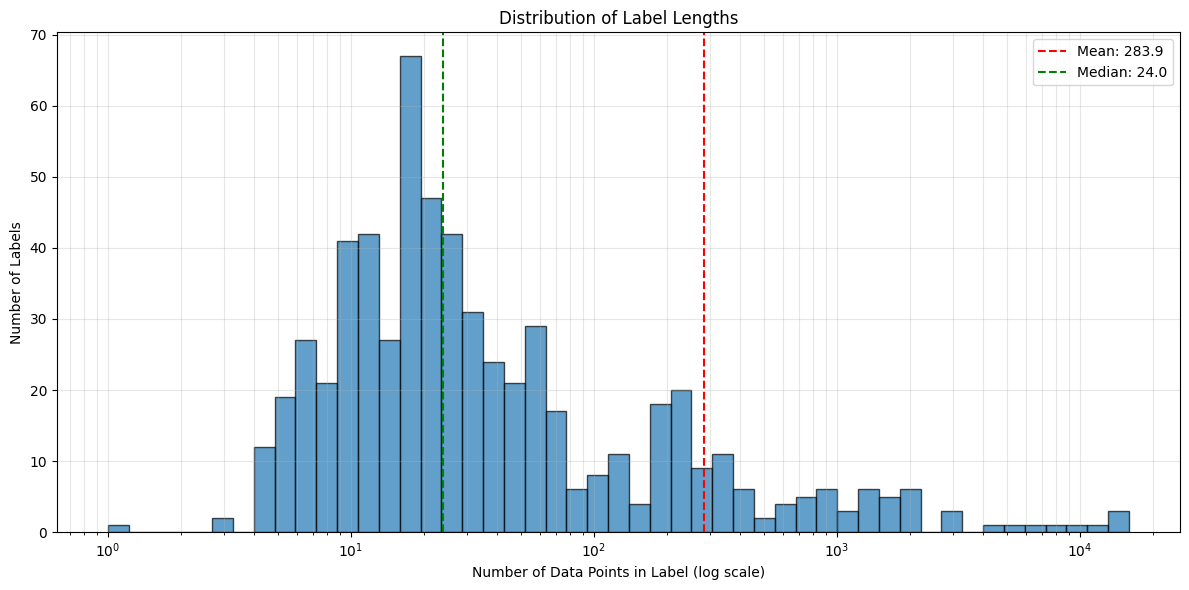

Total labels: 612
Mean length: 283.92
Median length: 24.00
Min length: 1
Max length: 15943


In [5]:
# Draw graph where the x axis is the number of data points in a label and the y is the number of different labels with similar length
# To get data points of a given label, first find the file which belongs to the label, next find the indices of the datapoints nearest to start and end of the label,
#  then cut between these to a dataframe and get its length

import matplotlib.pyplot as plt
import numpy as np

data_dir = "./data"
labels_path = data_dir + "/labels.json"

def get_dataframe_of_label(single_label: dict, files: list):
    """
    Get the dataframe slice corresponding to a single label.
    
    Args:
        single_label: Label dictionary with 'file', 'start', 'end' keys
        files: List of file dictionaries from labels.json
    
    Returns:
        DataFrame slice for this label, or None if error
    """
    try:
        # Find the file entry
        file_id = single_label['file']
        file_entry = next((f for f in files if f['id'] == file_id), None)
        
        if not file_entry:
            return None
        
        # Load the CSV file
        csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
        if not os.path.exists(csv_path):
            return None
        
        df = pd.read_csv(csv_path)
        
        # Get start and end timestamps
        start_ts = single_label.get('start')
        end_ts = single_label.get('end')
        
        if start_ts is None or end_ts is None:
            return None
        
        # Get the time column
        time_col = df.columns[0]
        
        # Find rows between start and end (inclusive)
        mask = (df[time_col] >= start_ts) & (df[time_col] <= end_ts)
        return df[mask]
        
    except Exception as e:
        print(f"Error processing label: {e}")
        return None

def collect_lengths(labels_json: dict):
    """
    Collect the lengths (number of data points) of all labels.
    
    Args:
        labels_json: Dictionary with 'labels' and 'files' keys
    
    Returns:
        List of label lengths
    """
    labels = labels_json.get("labels", [])
    files = labels_json.get("files", [])
    
    lengths = []
    for label in labels:
        df = get_dataframe_of_label(label, files)
        if df is not None and len(df) > 0:
            lengths.append(len(df))
    
    return lengths

def draw_graph(labels_json: dict):
    """
    Draw histogram of label lengths with logarithmic x-axis.
    
    Args:
        labels_json: Dictionary with 'labels' and 'files' keys
    """
    lengths = collect_lengths(labels_json)
    
    if not lengths:
        print("No valid label lengths to plot")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Use logarithmic bins for better visualization
    min_len = max(1, min(lengths))  # Avoid log(0)
    max_len = max(lengths)
    bins = np.logspace(np.log10(min_len), np.log10(max_len), 50)
    
    plt.hist(lengths, bins=bins, edgecolor='black', alpha=0.7)
    plt.xscale('log')
    plt.xlabel('Number of Data Points in Label (log scale)')
    plt.ylabel('Number of Labels')
    plt.title('Distribution of Label Lengths')
    plt.grid(True, alpha=0.3, which='both')
    
    # Add statistics
    mean_len = sum(lengths) / len(lengths)
    median_len = sorted(lengths)[len(lengths) // 2]
    plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
    plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total labels: {len(lengths)}")
    print(f"Mean length: {mean_len:.2f}")
    print(f"Median length: {median_len:.2f}")
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")

# Load the labels and draw the graph
with open(labels_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

draw_graph(labels_data)

In [ ]:
# I'm a bit worried that some files were not labeled all the way through, so they contain some false negative data
# i want to visualize this somehow on a graph which shows the distribution of labels in files for each file

def analyze_label_coverage_per_file(labels_json: dict):
    """
    Analyze how labels are distributed across each file.
    Returns a dictionary mapping file_id to label coverage information.
    """
    labels = labels_json.get("labels", [])
    files = labels_json.get("files", [])
    
    # Group labels by file
    labels_by_file = {}
    for label in labels:
        file_id = label['file']
        if file_id not in labels_by_file:
            labels_by_file[file_id] = []
        labels_by_file[file_id].append(label)
    
    # Calculate coverage for each file
    file_coverage = {}
    for file_entry in files:
        file_id = file_entry['id']
        if file_id not in labels_by_file:
            continue
        
        # Load the CSV to get total length
        csv_path = os.path.join(data_out_dir, file_entry['normalized_file'])
        if not os.path.exists(csv_path):
            continue
        
        df = pd.read_csv(csv_path)
        time_col = df.columns[0]
        
        file_start = df[time_col].iloc[0]
        file_end = df[time_col].iloc[-1]
        total_duration = file_end - file_start if file_end != file_start else 1
        
        # Collect label positions (normalized to 0-1 range)
        label_positions = []
        for label in labels_by_file[file_id]:
            start_ts = label.get('start')
            end_ts = label.get('end')
            
            if start_ts and end_ts:
                # Normalize to 0-1 range
                norm_start = (start_ts - file_start) / total_duration if total_duration > 0 else 0
                norm_end = (end_ts - file_start) / total_duration if total_duration > 0 else 0
                label_positions.append((norm_start, norm_end))
        
        file_coverage[file_id] = {
            'normalized_file': file_entry['normalized_file'],
            'label_count': len(labels_by_file[file_id]),
            'label_positions': label_positions,
            'file_start': file_start,
            'file_end': file_end
        }
    
    return file_coverage

def draw_label_distribution_graph(labels_json: dict):
    """
    Draw a graph showing label distribution across files.
    Each row represents a file, with labels shown as horizontal bars.
    """
    coverage = analyze_label_coverage_per_file(labels_json)
    
    if not coverage:
        print("No coverage data to plot")
        return
    
    # Sort files by label count for better visualization
    sorted_files = sorted(coverage.items(), key=lambda x: x[1]['label_count'], reverse=True)
    
    # Limit to top 30 files for readability
    top_n = 30
    if len(sorted_files) > top_n:
        sorted_files = sorted_files[:top_n]
        print(f"Showing top {top_n} files with most labels")
    
    fig, ax = plt.subplots(figsize=(14, max(8, len(sorted_files) * 0.3)))
    
    for idx, (file_id, data) in enumerate(sorted_files):
        y_pos = len(sorted_files) - idx - 1  # Reverse order for top-to-bottom
        
        # Draw a background line for the entire file
        ax.plot([0, 1], [y_pos, y_pos], 'lightgray', linewidth=2, alpha=0.3)
        
        # Draw each label as a horizontal bar
        for start, end in data['label_positions']:
            ax.plot([start, end], [y_pos, y_pos], 'b', linewidth=4, solid_capstyle='butt')
    
    # Set labels
    ax.set_yticks(range(len(sorted_files)))
    ax.set_yticklabels([f"{data['normalized_file']} ({data['label_count']})" 
                         for _, data in sorted_files], fontsize=8)
    ax.set_xlabel('Position in File (normalized 0-1)')
    ax.set_ylabel('File (label count)')
    ax.set_title('Label Distribution Across Files')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_files = len(coverage)
    avg_labels = sum(d['label_count'] for d in coverage.values()) / total_files if total_files > 0 else 0
    
    print(f"\nSummary:")
    print(f"Total files with labels: {total_files}")
    print(f"Average labels per file: {avg_labels:.2f}")
    
    # Check for potential incomplete labeling
    sparse_files = []
    for file_id, data in coverage.items():
        if data['label_positions']:
            # Check if all labels are in first or last 20% of file
            starts = [pos[0] for pos in data['label_positions']]
            ends = [pos[1] for pos in data['label_positions']]
            
            if max(ends) < 0.3 or min(starts) > 0.7:
                sparse_files.append((data['normalized_file'], min(starts), max(ends)))
    
    if sparse_files:
        print(f"\nPotential incomplete labeling detected in {len(sparse_files)} files:")
        for filename, min_pos, max_pos in sparse_files[:10]:
            print(f"  {filename}: labels only in range {min_pos:.2f}-{max_pos:.2f}")

# Load the labels and draw the distribution graph
with open(labels_path, 'r', encoding='utf-8') as f:
    labels_data = json.load(f)

draw_label_distribution_graph(labels_data)